# Think Gaussian Shells with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = \log(e^{f(x,c_1,r_1,w_1)} + e^{f(x,c_2,r_2,w_2)}) $

where $f(x,c,r,w) = -\frac{1}{2 w^2}(|x - c| - r)^2 - \log(\sqrt(2 \pi w^2))$

and

$P(x) = \mathcal{U}[x \mid -6, 6 \pi]$.

## Overview

We'll cover the following topics:

1. How to handle thin curving degeneracies and multimodal behaviour with JAXNS.
2. How to use the `prior_chain` outside the nested sampler, e.g. to sample/plot.
3. How to brute-force compute the evidence for comparison.

In [1]:

from jaxns.nested_sampler.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior
from jaxns.utils import summary, analytic_log_evidence
from jaxns.internals.maps import prepare_func_args
from jaxns.plotting import plot_cornerplot, plot_diagnostics
from jax import random, jit, vmap
from jax import numpy as jnp
import pylab as plt

In [2]:
def log_likelihood(theta, **kwargs):
    def log_circ(theta, c, r, w):
        return -0.5*(jnp.linalg.norm(theta - c) - r)**2/w**2 - jnp.log(jnp.sqrt(2*jnp.pi*w**2))
    w1=w2=jnp.array(0.1)
    r1=r2=jnp.array(2.)
    c1 = jnp.array([0., -3.])
    c2 = jnp.array([0., 3.])
    return jnp.logaddexp(log_circ(theta, c1,r1,w1) , log_circ(theta,c2,r2,w2))


with PriorChain() as prior_chain:
    UniformPrior('theta', low=-6.*jnp.ones(2), high=6.*jnp.ones(2))

log_Z_true = analytic_log_evidence(prior_chain=prior_chain, log_likelihood=log_likelihood, S=250)
print(f"True log(Z)={log_Z_true}")

INFO[2022-03-03 01:59:30,839]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-03-03 01:59:30,840]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-03-03 01:59:30,841]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-03-03 01:59:30,842]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING[2022-03-03 01:59:30,908]: Function log_likelihood has **varkw parameter, and is being dropped.


True log(Z)=-1.7456418720467646


WARNING[2022-03-03 01:59:42,087]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
WARNING[2022-03-03 01:59:42,097]: Function log_likelihood has **varkw parameter, and is being dropped.


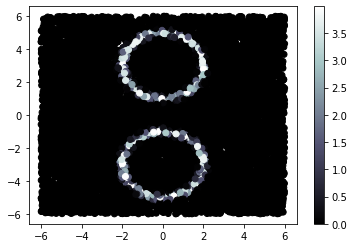

In [4]:
# To use the prior_chain to sample from, e.g. for plotting, we should first build it. This typically gets done inside the nested sampler, and if not should be done manually.
prior_chain.build()

theta = vmap(lambda key: prior_chain(prior_chain.sample_U_flat(key)))(
    random.split(random.PRNGKey(0), 10000))
# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(lambda theta: prepare_func_args(log_likelihood)(**theta))(theta)
sc = plt.scatter(theta['theta'][:, 0], theta['theta'][:, 1], c=jnp.exp(lik), cmap='bone')
plt.colorbar(sc)
plt.show()

In [5]:
# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(log_likelihood, prior_chain)
# We jit-compile
ns = jit(ns)
# We run, with any parameters desired. In this case, without any tuning.
results = ns(random.PRNGKey(4525325))


WARNING[2022-03-03 02:00:48,390]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
WARNING[2022-03-03 02:00:48,427]: Function log_likelihood has **varkw parameter, and is being dropped.
WARNING[2022-03-03 02:00:48,621]: Function log_likelihood has **varkw parameter, and is being dropped.


In [6]:
# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 48381
# samples: 904
# likelihood evals / sample: 53.5
--------
logZ=-1.71 +- 0.16
H=16.0
ESS=144
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 0.1 +- 1.4 | -1.9 / 0.2 / 1.9 | -1.9 | 1.0
theta[1]: -0.0 +- 3.3 | -4.8 / 0.0 / 4.5 | 3.1 | 4.7
--------


'--------\nTermination Conditions:\nSmall remaining evidence\n--------\n# likelihood evals: 48381\n# samples: 904\n# likelihood evals / sample: 53.5\n--------\nlogZ=-1.71 +- 0.16\nH=16.0\nESS=144\n--------\ntheta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntheta[0]: 0.1 +- 1.4 | -1.9 / 0.2 / 1.9 | -1.9 | 1.0\ntheta[1]: -0.0 +- 3.3 | -4.8 / 0.0 / 4.5 | 3.1 | 4.7\n--------'

WARNING[2022-03-03 02:00:57,403]: No handles with labels found to put in legend.


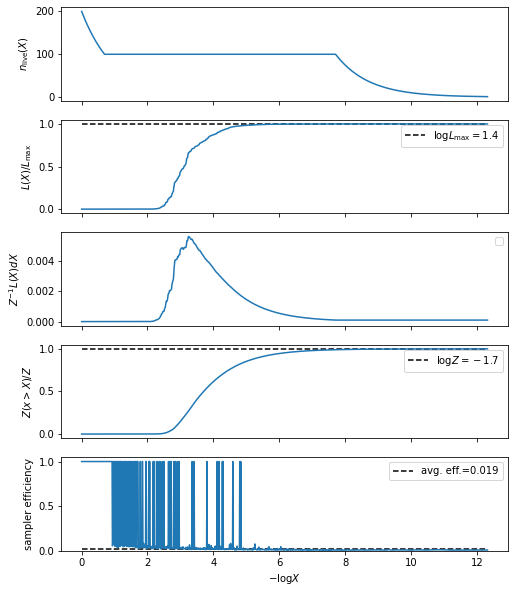

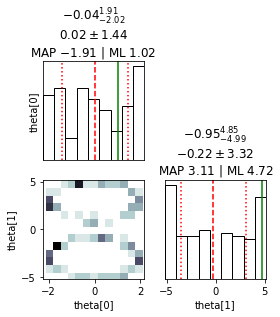

In [7]:
# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)